In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from shrinkage_estimators import covariance_linear_shrinkage
from shrinkage_estimators import precision_shrinkage

%matplotlib inline

In [2]:
DATA_PATH = "data"
OUTPUT_PATH = "output"
NSAMPLES = [21, 30]
NDIM = 18

In [3]:
def estimate_matrices(n):
    mocks_path = os.path.join(DATA_PATH, f"n{n}")
    nmocks = len([f for f in os.listdir(mocks_path) if not f.startswith('.')])
    
    for v in range(1, nmocks+1):
        in_fname = f"P_{NDIM}_{n}_v{v}.matrix"
        # Load mock power spectrum data
        P = np.loadtxt(os.path.join(mocks_path, in_fname))
        
        # Sample covariance matrix
        S = np.cov(P)
        
        targets = [
            np.diag(1/np.diag(S)), # [diag(S)]^{-1}
            np.diag(np.diag(np.linalg.inv(S))), # diag(S^{-1})
            np.identity(NDIM),
        ]
        labels = [
            "diag_then_inv", # label for [diag(S)]^{-1}
            "inv_then_diag", # label for diag(S^{-1})
            "Id",
        ]
        
        for target, label in zip(targets, labels):
            # Compute shrinkage estimate of precision matrix
            Pi_shrinkage, alpha, beta = precision_shrinkage.shrinkage(P, target)
            out_fname = f"pre_shrinkage_{label}_{NDIM}_{NDIM}_v{v}.matrix"
            np.savetxt(
                os.path.join(OUTPUT_PATH, f"n{n}", f"pre_shrinkage_{label}", out_fname),
                Pi_shrinkage,
                header=f"alpha={alpha}, beta={beta}"
            )
        
        # Compute shrinkage estimate of covariance matrix (target is automatically diag(S))
        # lmbda is the shrinkage intensity
        C_shrinkage, lmbda = covariance_linear_shrinkage.linear_shrinkage(P)
        out_fname = f"cov_shrinkage_{NDIM}_{NDIM}_v{v}.matrix"
        np.savetxt(
            os.path.join(OUTPUT_PATH, f"n{n}", "cov_shrinkage", out_fname),
            C_shrinkage,
            header=f"lambda={lmbda}"
        )

In [19]:
def plot_eval_spectra(n):
    mat_types = ["cov", "pre", "pre", "pre"]
    est_types = ["shrinkage", "shrinkage_diag_then_inv", "shrinkage_inv_then_diag", "shrinkage_Id"]
    labels = [
        "Inverse of shrinkage\ncovariance matrix",
        "Shrinkage precision with\ntarget [diag(S)]$^{-1}$",
        "Shrinkage precision with\ntarget diag(S$^{-1}$)",
        "Shrinkage precision with\ntarget $I_p$",
    ]
    
    fig, axs = plt.subplots(1, 4, sharey=True)
    fig.subplots_adjust(wspace=0)
    fig.set_size_inches(19.2, 3.6)
    
    min_eval = 1e10
    max_eval = 0
    
    emodes = np.arange(NDIM)+1
    for mat_type, est_type, ax, label in zip(mat_types, est_types, axs, labels):
        matrices_path = os.path.join(OUTPUT_PATH, f"n{n}", f"{mat_type}_{est_type}")
        
        for fname in [f for f in os.listdir(matrices_path) if not f.startswith('.')]:
            mat = np.loadtxt(os.path.join(matrices_path, fname))
            if mat_type == "pre":
                Pi = mat
            else:
                # Invert covariance matrix estimate
                Pi = np.linalg.inv(mat)
    
            evals = np.linalg.eigvalsh(Pi)
            if np.min(evals) > 0:
                min_eval = np.min([min_eval, np.min(evals)])
            max_eval = np.max([max_eval, np.max(evals)])
            
            ax.plot(emodes, evals)
            ax.set_title(label)
            ax.set_xticks(emodes[1::2])
            
    fig.supxlabel("Eigenmode", y=-0.02)
    axs[0].set_ylabel(r"Eigenvalue $[(h^3 \rm{Mpc}^{-3})^2]$")
    axs[0].set_yscale("log")
    axs[0].set_ylim(min_eval, max_eval)
    plt.show()

Eigenspectra for precision matrix estimates computed from 21 samples below


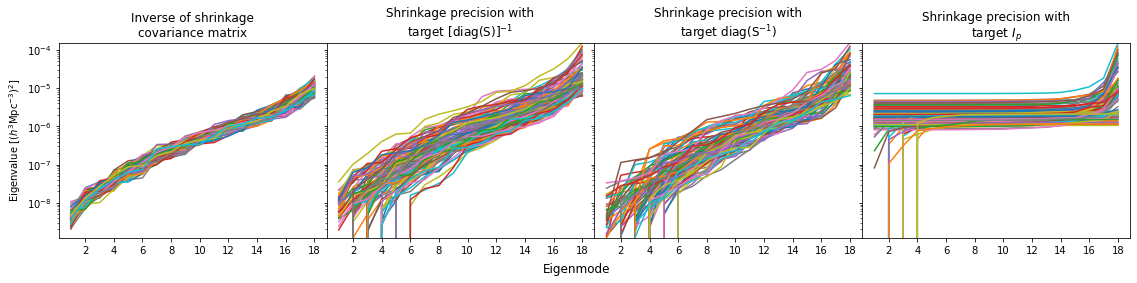

Eigenspectra for precision matrix estimates computed from 30 samples below


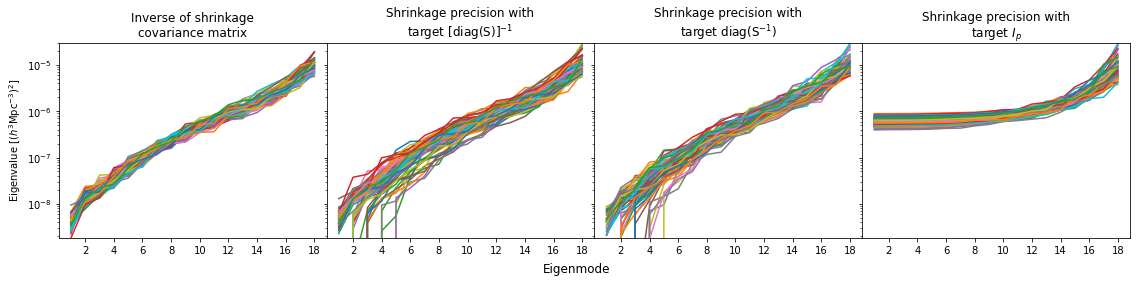

In [20]:
for n in NSAMPLES:
    estimate_matrices(n)
    
    print(f"Eigenspectra for precision matrix estimates computed from {n} samples below")
    plot_eval_spectra(n)

In [29]:
def get_pre_shrinkage_params(target_label, n):
    matrices_path = os.path.join(OUTPUT_PATH, f"n{n}", f"pre_shrinkage_{target_label}")
    
    alphas = []
    betas = []
    for fname in [f for f in os.listdir(matrices_path) if not f.startswith('.')]:
        
        with open(os.path.join(matrices_path, fname)) as f:
            first_line = f.readline()
            alpha_txt, beta_txt = first_line.split(",")
            alpha = float(alpha_txt.split("=")[1])
            beta = float(beta_txt.split("=")[1])
            
            alphas.append(alpha)
            betas.append(beta)
    
    return np.array(alphas), np.array(betas)

In [34]:
def get_cov_shrinkage_intensity(n):
    matrices_path = os.path.join(OUTPUT_PATH, f"n{n}", f"cov_shrinkage")
    
    lmbdas = []
    for fname in [f for f in os.listdir(matrices_path) if not f.startswith('.')]:
        
        with open(os.path.join(matrices_path, fname)) as f:
            first_line = f.readline()
            lmbda = float(first_line.split("=")[1])
            
            lmbdas.append(lmbda)
    
    return np.array(lmbdas)